# Using machine learning to predict future stock prices using technical and fundamental data

### Installation of libraries (consider conda install for working env first)


In [1]:
# !pip install altair
# !pip install pandas_ta
# !pip install requests_html
# !pip install requests
# pip install scikit-plot
# !pip install --user tensorflow
# pip install --upgrade pip
# !pip install yahoo_fin --upgrade
# !pip install yfinance --upgrade --no-cache-dir
# !pip install --user pycaret
# pip install scikit-learn==0.23.2
# pip install benzinga
# !pip install --user yahooquery
# !pip install pycaret
# !pip install mplfinance
# !pip install requests_cache
# !pip install certifi
# !pip install polygon-api-client~=1.0.0b
# !pip install --upgrade yfinance

### Importing relevant libraries

In [157]:
from polygon import RESTClient
import getpass
from datetime import date
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
 
# Returns the current local date
today = date.today()
dateOfMonth = today.day
monthNumber = today.month
yearNumber = today.year

In [3]:
import ftplib
import io
import pandas as pd
import pandas_ta as ta
import requests
import requests_html
import numpy as np

# from pycaret.classification import *
# from pycaret.regression import *

import yfinance as yf
from yahoo_fin.stock_info import get_data, get_top_crypto, get_analysts_info
import yahoo_fin.stock_info as si
import yahoo_fin.options as ops
from yahoo_fin.stock_info import *

# Dow: tickers_dow()
# Nasdaq: tickers_nasdaq()
# S&P500: tickers_sp500()
# Others: tickers_other()

# import tensorflow as tf
import altair as alt

# from benzinga import financial_data
# from benzinga import news_data

import mplfinance as mpf

import requests_cache

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

import metricFxns
from metricFxns import *
import vizFxns
from vizFxns import *

from sklearn import metrics
from sklearn import datasets

from yahooquery import Ticker

import ssl
import certifi
import urllib


### Yahoo_fin has two modules - stock_info and options.
---------
#### Stock_info has the following methods:

#### get_analysts_info(), get_balance_sheet(), get_cash_flow(), get_data(), get_day_gainers(), get_day_losers(), get_day_most_active(), get_holders(), get_income_statement(), get_live_price(), get_quote_table(), get_top_crypto(), get_stats(), get_stats_valuation(), tickers_dow(), tickers_nasdaq(), tickers_other(), tickers_sp500()
---------
#### And options has:

#### get_calls(), get_expiration_dates(), get_options_chain(), get_puts()
---------

#### And there are the methods you can’t use without requests_html are:

#### stock_info module, get_day_gainers(), get_day_most_active(), get_day_losers(), get_top_crypto(), get_expiration_dates()
---------

### Pulling data

In [4]:
# apiKey = getpass.getpass()
# client = RESTClient(apiKey)
# from polygon.rest import models

In [5]:
from yahoo_fin import stock_info as si

otherTickers = si.tickers_other(include_company_data = True)
nasdaqTickers = si.tickers_nasdaq(include_company_data = True)
allStocks = pd.concat([otherTickers,nasdaqTickers])
stockMarketTickers = list(allStocks['ACT Symbol'].unique())
nasdaqTicks = list(nasdaqTickers['Symbol'].unique())

In [6]:
# ticker: case insensitive ticker of the desired stock/bond
# start_date: date you want the data to start from (mm/dd/yyyy)
# end_date: date you want the data to end (mm/dd/yyyy)
# index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
# interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.
# get_data(ticker, start_date = None, end_date = None, index_as_date = True, interval = “1d”)


In [7]:
# session = requests_cache.CachedSession("yfinance.cache")
# session.headers["User-Agent"] = "prices-notebook/1.0"

# Indices
# dji = yf.Ticker("^DJI", session=session)         # DJIA
# gspc = yf.Ticker("^GSPC", session=session)       # S&P 500
# ixic = yf.Ticker("^IXIC", session=session)       # NASDAQ Composite

# Cryptocurrency
# btc_usd = yf.Ticker("BTC-USD", session=session)  # Bitcoin/USD

In [8]:
currentDate = str(monthNumber) + "/" + str(dateOfMonth) + "/" + str(yearNumber)
yearPrior = str(monthNumber) + "/" + str(dateOfMonth+1) + "/" + str(yearNumber-1)
yearPrior

'5/26/2023'

In [9]:
roth = pd.read_csv("D:\Roth.csv")
indv = pd.read_csv("D:\Indv.csv")

roth.columns = list(roth.iloc[1].values)
roth = roth.iloc[2:]
roth = roth.iloc[:-1]

indv.columns = list(indv.iloc[1].values)
indv = indv.iloc[2:]
indv = indv.iloc[:-1]

In [10]:
indv = indv[['Symbol','% Of Account','Security Type']]
roth = roth[['Symbol','% Of Account','Security Type']]

In [11]:
timeseriesDf = pd.DataFrame()
sector_etfs = ['XLE','XLV','XLU','XLI','GDX','XLK','XLY','XLB','XOP','XHB','XME','XTL']
current_portfolio = list(indv['Symbol'].values)
ticker_nm = 'ADBE'

In [12]:

for ticker in current_portfolio: #sector_etfs
    try:
        timeseriesDf = pd.concat([timeseriesDf,get_data(ticker,start_date=yearPrior ,  end_date=currentDate, index_as_date = True, interval="1mo")])
    except:
        pass


timeseriesDf = timeseriesDf.reset_index()
timeseriesDf = timeseriesDf.rename(columns={'index':'date'})
timeseriesDf.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2023-06-01,116.970001,123.180000,114.160004,120.250000,119.383118,51386600,A
1,2023-07-01,120.019997,130.000000,115.660004,121.769997,121.123016,38312400,A
2,2023-08-01,121.779999,129.990005,117.330002,121.070000,120.426743,41877200,A
3,2023-09-01,122.690002,123.680000,109.000000,111.820000,111.225891,39797000,A
4,2023-10-01,110.900002,113.830002,96.800003,103.370003,102.820786,46915400,A


In [14]:
historyDfs = []
tickerLst = ['ADBE']
for ticker in tickerLst:#current_portfolio: #['XLV'] #sector_etfs #stockMarketTickers
    try: 
        yahooTickerData = yf.Ticker(ticker) #, session=session
        yahooHistory = yahooTickerData.history(period="5y", auto_adjust=False, back_adjust=False) #"max"
        yahooHistory['Ticker']=ticker
        historyDfs.append(yahooHistory)
    except:
        print(ticker)
        pass

historyDfFull = pd.concat(historyDfs)
historyDfFull.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,,
2019-05-28 00:00:00-04:00,276.489990,281.450012,275.369995,278.250000,278.250000,2475800,0.0,0.0,ADBE
2019-05-29 00:00:00-04:00,275.290009,276.799988,272.279999,273.380005,273.380005,1806000,0.0,0.0,ADBE
2019-05-30 00:00:00-04:00,274.429993,275.089996,272.429993,274.510010,274.510010,1601100,0.0,0.0,ADBE
2019-05-31 00:00:00-04:00,271.279999,272.910004,268.750000,270.899994,270.899994,2526600,0.0,0.0,ADBE
2019-06-03 00:00:00-04:00,270.510010,272.809998,257.529999,259.029999,259.029999,3903400,0.0,0.0,ADBE


In [15]:
def add_rsi(df, periods=14):
    close_diff = df["Close"].diff()
    up = close_diff.clip(lower=0)
    down = -1 * close_diff.clip(upper=0)
    ma_up = up.ewm(
        com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(
        com=periods-1, adjust=True, min_periods=periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))
    df["RSI"] = rsi

rsiDfs = []
for ticker in tickerLst:#current_portfolio:
    histDf = historyDfFull[historyDfFull['Ticker']==ticker]
    add_rsi(histDf)
    add_macd(histDf)
    rsiDfs.append(histDf)
rsiDfFull = pd.concat(rsiDfs)
# rsiDfFull[(rsiDfFull.index==currentDate)&(rsiDfFull.Open>20)&(rsiDfFull.RSI<65)].sort_values(by='RSI')
rsiDfFull.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Ticker,RSI,MACD,MACD-s,MACD-h
Date,,,,,,,,,,,,,
2019-05-28 00:00:00-04:00,276.489990,281.450012,275.369995,278.250000,278.250000,2475800,0.0,0.0,ADBE,NaN,NaN,NaN,NaN
2019-05-29 00:00:00-04:00,275.290009,276.799988,272.279999,273.380005,273.380005,1806000,0.0,0.0,ADBE,NaN,NaN,NaN,NaN
2019-05-30 00:00:00-04:00,274.429993,275.089996,272.429993,274.510010,274.510010,1601100,0.0,0.0,ADBE,NaN,NaN,NaN,NaN
2019-05-31 00:00:00-04:00,271.279999,272.910004,268.750000,270.899994,270.899994,2526600,0.0,0.0,ADBE,NaN,NaN,NaN,NaN
2019-06-03 00:00:00-04:00,270.510010,272.809998,257.529999,259.029999,259.029999,3903400,0.0,0.0,ADBE,NaN,NaN,NaN,NaN


## Forecasting

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

In [17]:
endWeekDate = str(yearNumber)+"-"+str(monthNumber)+"-"+str(dateOfMonth)
startWeekDate = str(yearNumber-5)+"-"+str(monthNumber)+"-"+str(dateOfMonth+1)

In [18]:
rsiDfFull = rsiDfFull.dropna(subset=['RSI'])

In [19]:
rsiDfFull[rsiDfFull['Ticker']==ticker].index

DatetimeIndex(['2019-06-17 00:00:00-04:00', '2019-06-18 00:00:00-04:00',
               '2019-06-19 00:00:00-04:00', '2019-06-20 00:00:00-04:00',
               '2019-06-21 00:00:00-04:00', '2019-06-24 00:00:00-04:00',
               '2019-06-25 00:00:00-04:00', '2019-06-26 00:00:00-04:00',
               '2019-06-27 00:00:00-04:00', '2019-06-28 00:00:00-04:00',
               ...
               '2024-05-13 00:00:00-04:00', '2024-05-14 00:00:00-04:00',
               '2024-05-15 00:00:00-04:00', '2024-05-16 00:00:00-04:00',
               '2024-05-17 00:00:00-04:00', '2024-05-20 00:00:00-04:00',
               '2024-05-21 00:00:00-04:00', '2024-05-22 00:00:00-04:00',
               '2024-05-23 00:00:00-04:00', '2024-05-24 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=1245, freq=None)

In [20]:
# Set the date as index 
# Select the proper time period for weekly aggreagation

resampleDfs = []
for ticker in tickerLst:#current_portfolio:
    resampleDf = rsiDfFull[rsiDfFull['Ticker']==ticker]

    # # Specify the desired frequency and generate a date range
    # desired_freq = 'B'  # Business day frequency (excluding weekends)
    # date_range = pd.date_range(start=resampleDf.index.min(), end=resampleDf.index.max(), freq=desired_freq)

    # # Reindex the DataFrame using the generated date range
    # resampleDf = resampleDf.reindex(date_range)

    # resampleDf.index.freq = pd.infer_freq(resampleDf.index)
    # print(resampleDf.index.freq)
    # resampleDf = resampleDf[startWeekDate:endWeekDate].resample('W').sum()
    
    resampleDfWeekly = resampleDf[startWeekDate:endWeekDate].resample('W').mean()
    resampleDfWeekly.index.freq = pd.infer_freq(resampleDfWeekly.index)
    resampleDfWeekly['Ticker'] = ticker
    resampleDfs.append(resampleDfWeekly)

resampleRsiDfFull = pd.concat(resampleDfs)
resampleRsiDfFull.head()
print(resampleRsiDfFull[resampleRsiDfFull['Ticker']==ticker].index.freq)


<Week: weekday=6>


<Week: weekday=6>


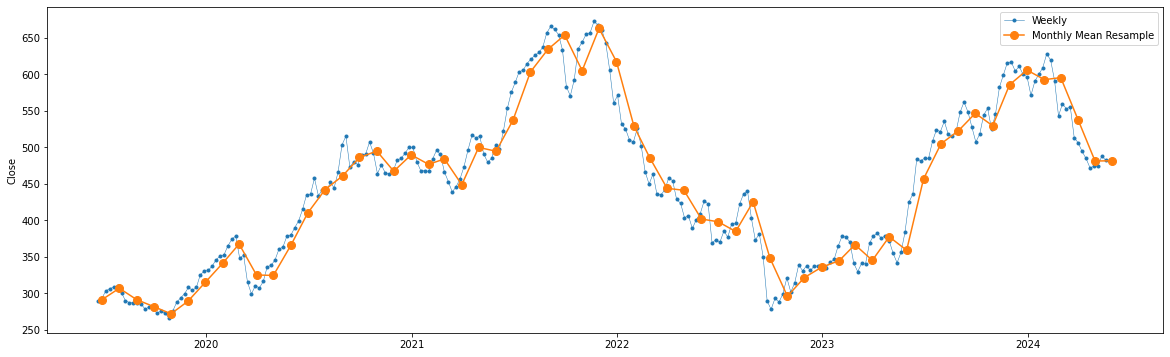

In [22]:
import warnings
import matplotlib.pyplot as plt
for ticker in tickerLst:
    y = resampleRsiDfFull[resampleRsiDfFull['Ticker']==ticker]['Close']
    y.index.freq = pd.infer_freq(resampleDfWeekly.index)
    print(y.index.freq)
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
    ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
    ax.set_ylabel('Close')
    ax.legend()

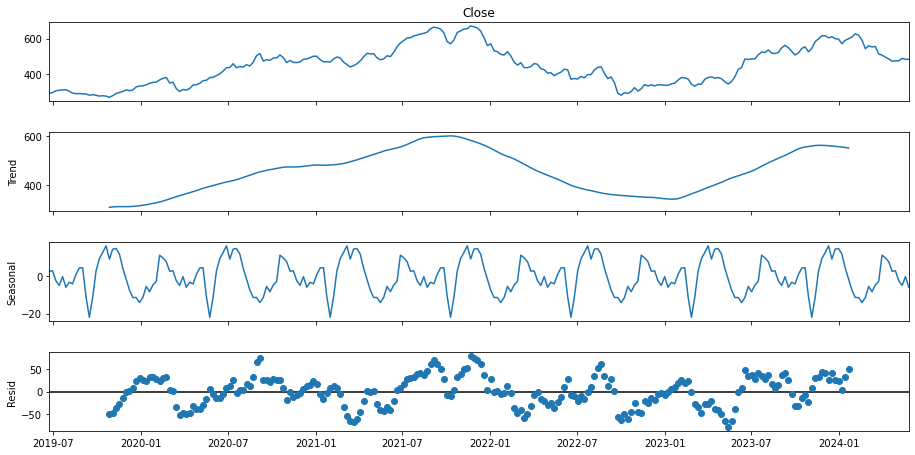

In [23]:
import statsmodels.api as sm
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=int((len(y)/7)))
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose (y)

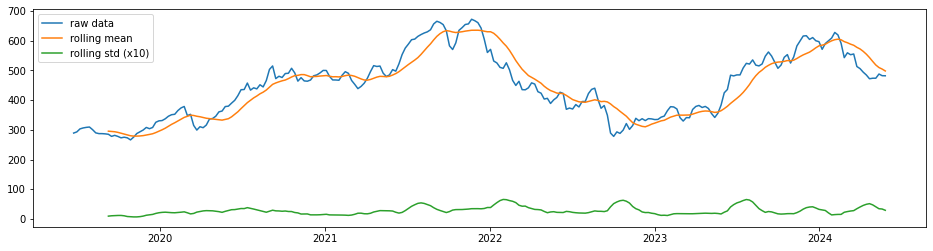

In [24]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [25]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.964
P-value = 0.303
Critical values :
	1%: -3.4561550092339512 - The data is not stationary with 99% confidence
	5%: -2.8728972266578676 - The data is not stationary with 95% confidence
	10%: -2.5728222369384763 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -3.821
P-value = 0.003
Critical values :
	1%: -3.4577787098622674 - The data is  stationary with 99% confidence
	5%: -2.873608704758507 - The data is  stationary with 95% confidence
	10%: -2.573201765981991 - The data is  stationary with 90% confidence


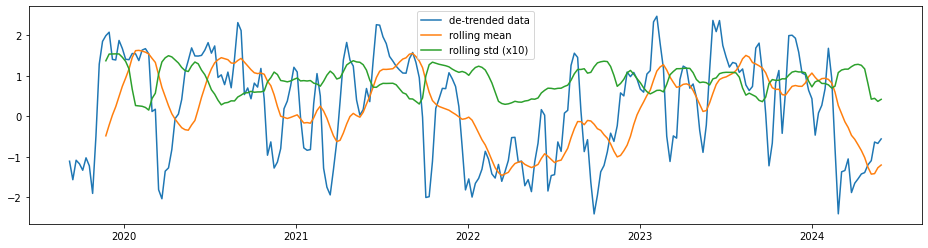

In [26]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.401
P-value = 0.000
Critical values :
	1%: -3.4602906385073884 - The data is  stationary with 99% confidence
	5%: -2.874708679520702 - The data is  stationary with 95% confidence
	10%: -2.573788599127782 - The data is  stationary with 90% confidence


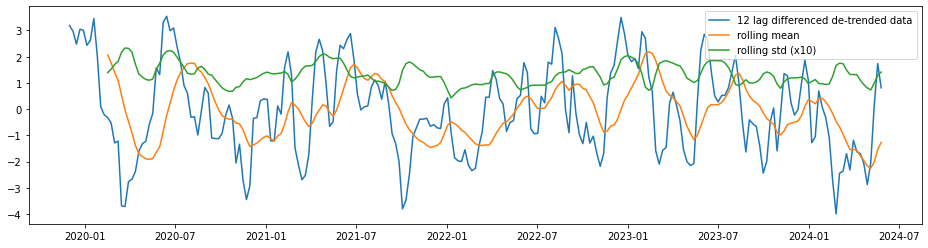

In [27]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [59]:
print(currentDate)
current_date = datetime.strptime(currentDate, "%m/%d/%Y")

# Subtract 4 months from the current date
endTrainingDate = current_date - relativedelta(months=4)
# Add 4 days to the current date
endTrainingDate += timedelta(days=4)

# Set the start of the test week to be one week after the end training date
startTestWeekDate = endTrainingDate + timedelta(weeks=1)

# Generate formatted date strings
endTrainingWeekDateStr = endTrainingDate.strftime("%Y-%m-%d")
startTestWeekNearestWeekStr = startTestWeekDate.strftime("%Y-%m-%d")
startTestWeekDateStr = startTestWeekDate.strftime("%Y-%m-%d")

# Find the closest dates in y.index
endTrainingDate = y.index[y.index.get_loc(endTrainingDate, method='nearest')]
startTestWeekDate = y.index[y.index.get_loc(startTestWeekDate, method='nearest')]

# Print adjusted dates for debugging
print("Adjusted End Training Date:", endTrainingDate)
print("Adjusted Start Test Week Date:", startTestWeekDate)

5/25/2024
Adjusted End Training Date: 2024-01-28 00:00:00-05:00
Adjusted Start Test Week Date: 2024-02-04 00:00:00-05:00


C:\Users\npess\AppData\Local\Temp/ipykernel_3752/3352898395.py:36: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  endTrainingDate = y.index[y.index.get_loc(endTrainingDate, method='nearest')]
C:\Users\npess\AppData\Local\Temp/ipykernel_3752/3352898395.py:37: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  startTestWeekDate = y.index[y.index.get_loc(startTestWeekDate, method='nearest')]


In [60]:
# print(y.index.freq)

# y_to_train = y[:endTrainingWeekDate] # dataset to train
# y_to_val = y[startTestWeekDate:] # last X months for test  
# predict_date = len(y) - len(y[:startTestWeekDate]) # the number of data points for the test set

# # print(y.index.freq)

# y_to_train = y[:endTrainingWeekDate] # dataset to train
# y_to_val = y[startTestWeekDate:] # last X months for test  
# predict_date = len(y) - len(y[:startTestWeekDate]) # the number of data points for the test set


# print(y_to_train)
# print(y_to_val)
# print(predict_date)
# print(list(y.index))

# Slicing the series using the Timestamp objects
y_to_train = y[:endTrainingDate]  # dataset to train
y_to_val = y[startTestWeekDate:]  # last X months for test

# Calculate the number of data points for the test set
predict_date = len(y) - len(y[:startTestWeekDate])

print("\ny_to_train:")
print(y_to_train)
print("\ny_to_val:")
print(y_to_val)
print("\npredict_date:")
print(predict_date)

# Additional debugging prints to verify slicing ranges
print("\nDate range in y:")
print(y.index.min(), "to", y.index.max())
print("End Training Date in y:", endTrainingDate in y.index)
print("Start Test Week Date in y:", startTestWeekDate in y.index)


y_to_train:
Date
2019-06-23 00:00:00-04:00   289.00599365
2019-06-30 00:00:00-04:00   292.88800049
2019-07-07 00:00:00-04:00   303.01000977
2019-07-14 00:00:00-04:00   306.22401123
2019-07-21 00:00:00-04:00   308.16000366
                                ...     
2023-12-31 00:00:00-05:00   596.61500549
2024-01-07 00:00:00-05:00   570.87748718
2024-01-14 00:00:00-05:00   590.36199951
2024-01-21 00:00:00-05:00   599.75749207
2024-01-28 00:00:00-05:00   608.75200195
Freq: W-SUN, Name: Close, Length: 241, dtype: float64

y_to_val:
Date
2024-02-04 00:00:00-05:00   627.72800293
2024-02-11 00:00:00-05:00   619.31199951
2024-02-18 00:00:00-05:00   591.09799805
2024-02-25 00:00:00-05:00   542.86000061
2024-03-03 00:00:00-05:00   559.20000000
2024-03-10 00:00:00-05:00   552.72000732
2024-03-17 00:00:00-04:00   555.20399780
2024-03-24 00:00:00-04:00   512.99199829
2024-03-31 00:00:00-04:00   505.95750427
2024-04-07 00:00:00-04:00   494.10799561
2024-04-14 00:00:00-04:00   484.48399658
2024-04-21

Additive: xt = Trend + Seasonal + Random
Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.
Multiplicative: xt = Trend * Seasonal * Random
The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.

Once you figure out which type of seasonality you’re dealing with in your data, you can identify the frequency of seasonality or m. For data with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with 2 years of data, and we aggregated it by week, so each data point is one week, so m = 52.

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 108.61


c:\FinancialPredictions\FinancialPredictions\vizFxns.py:86: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True, use_boxcox=True).fit()


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 79.18


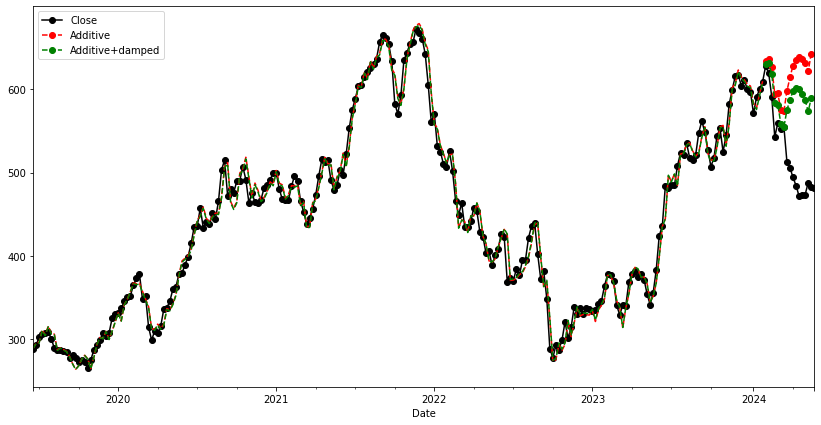

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
import importlib
importlib.reload(vizFxns)
from vizFxns import *
import numpy as np
vizFxns.holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)
# holt_win_sea(y, y_to_train,y_to_val,'additive',52, predict_date)

In [62]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,52)

C:\Users\npess\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\npess\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\npess\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\npess\AppData\Local\Packages\Pytho

The set of parameters with the minimum AIC is: SARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:1360.4239059162223


In [90]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    try:
        pred = results.get_prediction(start=pd.to_datetime(pred_date).tz_localize('America/New_York'), dynamic=False)
    except:
        pred = results.get_prediction(start=pred_date, dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    try:
        pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date).tz_localize('America/New_York'), dynamic=True, full_results=True)
    except:
        pred_dynamic = results.get_prediction(start=pred_date, dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [92]:
# startTestWeekNearestWeekStr
startTestWeekNearestWeekReal = y_to_val.index[0]#.strftime('%Y-%d-%m')
startTestWeekNearestWeekReal

Timestamp('2024-02-04 00:00:00-0500', tz='America/New_York', freq='W-SUN')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0745      0.373     -0.200      0.842      -0.806       0.657
ma.L1          0.3090      0.356      0.868      0.386      -0.389       1.007
ar.S.L52      -0.6595      0.079     -8.389      0.000      -0.814      -0.505
sigma2       431.1471     41.523     10.383      0.000     349.763     512.532


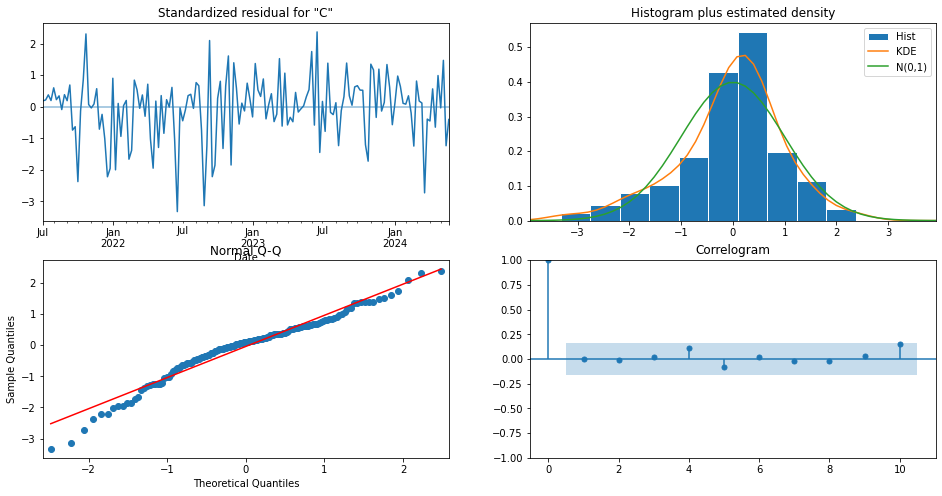

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 20.04


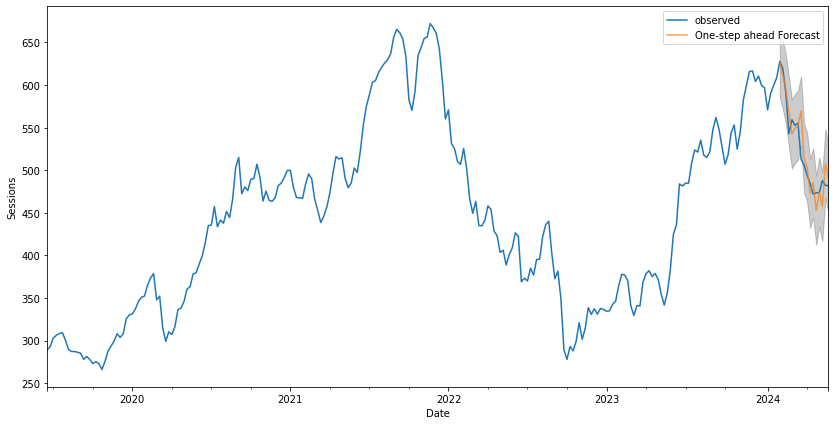

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 53.3


C:\Users\npess\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


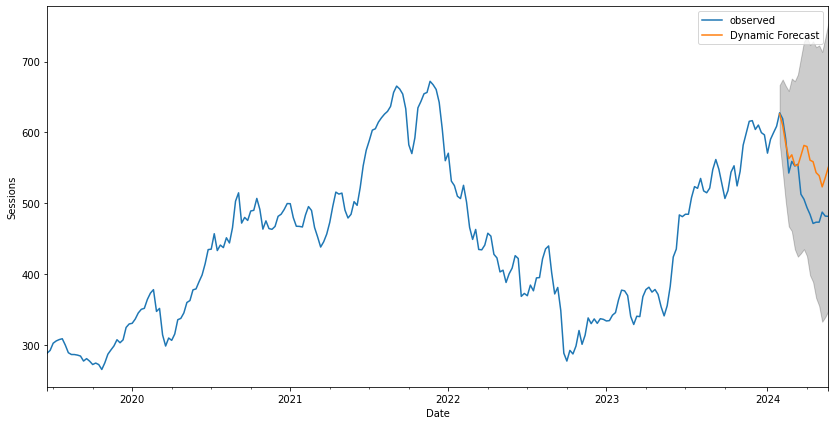

In [93]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,startTestWeekNearestWeekReal,y_to_val)
# model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2024-4-2',y_to_val)

In [199]:
plt.style.use('seaborn')
import matplotlib.ticker as ticker

ticker_nm = 'ADBE'


def forecast(model, predict_steps, y, ticker_nm):
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int()

    fig, ax = plt.subplots(figsize=(13, 4))
    
    # Plot observed data with specified color
    y.plot(ax=ax, label='Observed', color='#D08C60')
    
    # Plot forecasted data with specified color
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#797D62')

    # Fill between confidence intervals
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)

    # Customize plot appearance
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_title(f'{ticker_nm} 12 Month Forecast', loc='left', fontsize=20, fontweight='bold', color='#696969', pad=20)
    ax.xaxis.labelpad = 0  # Remove padding between label and plot
    ax.yaxis.labelpad = 0  # Remove padding between label and plot
    ax.yaxis.set_major_formatter('${:,.0f}'.format)

    # Remove background and gridlines
    ax.set_facecolor('none')
    ax.grid(False)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set color for axis labels and tick labels
    ax.xaxis.label.set_color('#696969')
    ax.yaxis.label.set_color('#696969')
    ax.tick_params(axis='x', colors='#696969')
    ax.tick_params(axis='y', colors='#696969')

    # Show legend
    ax.legend()

    # Specify the directory path
    directory = "C:/Financial Outputs/Overviews"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Specify the path and filename for the PNG image
    forecast_file = os.path.join(directory, "forecast_chart")

    plt.savefig(forecast_file)

    # Show plot
    plt.show()

    # Produce the forecasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date', 'Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date', 'Lower Bound', 'Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')

    return final_table

C:\Users\npess\AppData\Local\Temp/ipykernel_3752/1474488277.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


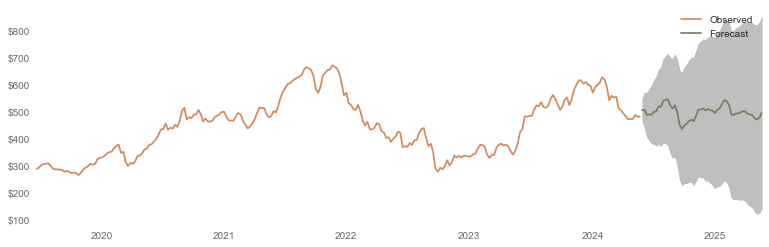

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2024-06-02 00:00:00-04:00,506.01092025,465.31406816,546.70777234
1,2024-06-09 00:00:00-04:00,507.26504602,442.61021824,571.91987381
2,2024-06-16 00:00:00-04:00,488.47408536,407.02888128,569.91928944
3,2024-06-23 00:00:00-04:00,490.36051960,395.01039326,585.71064594
4,2024-06-30 00:00:00-04:00,489.38767638,381.91870186,596.85665089


In [200]:
final_table = forecast(model,52,y,ticker_nm)
final_table.head()

In [112]:
target_price_floor = final_table['Lower Bound'].values[-1:][0].astype(int)
print(target_price_floor)

target_price_mean = final_table['Predicted_Mean'].values[-1:][0].astype(int)
print(target_price_mean)

target_price_ceiling = final_table['Upper Bound'].values[-1:][0].astype(int)
print(target_price_ceiling)

140
497
853


In [113]:
last_price = y.values[-1:][0]
last_price

481.8419982910156

In [114]:
floor_change = 100 * (1 - (last_price/target_price_floor))
print(floor_change.astype(int).astype(str)+'%')
mean_change = 100 * (1 - (last_price/target_price_mean))
print(mean_change.astype(int).astype(str)+'%')
ceiling_change = 100 * (1 - (last_price/target_price_ceiling))
print(ceiling_change.astype(int).astype(str)+'%')

-244%
3%
43%
